In [1]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from generate_modes import *
import qnm

In [2]:
chi_f, M_f = 0.692, 0.9525
omegas, taus=[],[]
for n in range(8):
	qnm_mode = qnm.modes_cache(s=-2,l=2,m=2,n=n)
	omega_complex, _, _ = qnm_mode(a=chi_f)
	omega = np.real(omega_complex)/M_f
	tau=np.abs(1./np.imag(omega_complex))*M_f
	omegas.append(omega)
	taus.append(tau)

In [3]:
def damped_sine(t,tau, omega, phi, A):
	return A*np.exp(-t/tau)*np.cos(t*omega+phi)

In [4]:
def damped_sine_complex(t, phi, A, tau=taus[0], omega=omegas[0]):	
	t_real = t[:int(t.size/2)]
	t_imag = t[int(t.size/2):]
	real_out = A*np.exp(-t_real/tau)*np.cos(t_real*omega+phi)
	imag_out = -A*np.exp(-t_imag/tau)*np.sin(t_imag*omega+phi)
	return np.hstack([real_out, imag_out])

In [5]:
def damped_sine_complex_general(t, phi_c, phi_s, A_c, A_s, tau_c, tau_s, omega_c, omega_s):	
	t_real = t[:int(t.size/2)]
	t_imag = t[int(t.size/2):]
	real_out = A_c*np.exp(-t_real/tau_c)*np.cos(t_real/omega_c+phi_c)
	imag_out = -A_s*np.exp(-t_imag/tau_s)*np.sin(t_imag/omega_s+phi_s)
	return np.hstack([real_out, imag_out])

In [79]:
def damped_sine_complex_overtone(t, phi0, phi1, phi2, phi3, phi4, phi5, phi6, phi7, A0, A1, A2, A3, A4, A5, A6, A7):
	phis = [phi0, phi1, phi2, phi3, phi4, phi5, phi6, phi7]
	As = [A0, A1, A2, A3, A4, A5, A6, A7]
	ns = np.arange(1,len(As)+1,1)
	t_real = t[:int(t.size/2)]
	t_imag = t[int(t.size/2):]
	real_out=0.0
	imag_out=0.0
	for (n, tau, omega, phi, A) in zip(ns, taus, omegas, phis, As):
		real_out += A*np.exp(-t_real/tau)*np.cos(t_real*omega+phi)
		imag_out += -A*np.exp(-t_imag/tau)*np.sin(t_imag*omega+phi)
	return np.hstack([real_out, imag_out])

def damped_sine_complex_overtone_(t, *p):
    n = int(len(p)/2)
    ns = np.arange(1,n+1,1)
    t_real = t[:int(t.size/2)]
    t_imag = t[int(t.size/2):]
    real_out=0.0
    imag_out=0.0
    phis = np.copy(p[:n])
    As = np.copy(p[n:])
    for (n, tau, omega, phi, A) in zip(ns, taus, omegas, phis, As):
        real_out += A*np.exp(-t_real/tau)*np.cos(t_real*omega+phi)
        imag_out += -A*np.exp(-t_imag/tau)*np.sin(t_imag*omega+phi)
    return np.hstack([real_out, imag_out])

In [30]:
def mismatch(htrue,hfit,t):
	htrue_hfit = np.trapz(np.real(htrue*np.conj(hfit)), x=t)
	htrue_htrue = np.trapz(np.abs(htrue)**2, x=t)
	hfit_hfit = np.trapz(np.abs(hfit)**2, x=t)
	return 1.-htrue_hfit/np.sqrt(htrue_htrue*hfit_hfit)

Prepare pure GR waveform

In [88]:
ell=0.0
t_start = 0.0
strain_out=0.+0.j
time, strain_22 = dCS_hlm(ell,(2,2))
time, strain_2m2 = dCS_hlm(ell,(2,-2))
strain_22*=1#SpinWeightedSphericalHarmonic(0.0, 0, -2, mode[0], mode[1])
t_RD_22, h_RD_22 = get_ringdown(time, strain_22)
t_RD = t_RD_22[t_RD_22>=t_start]
h_RD = h_RD_22[t_RD_22>=t_start]
h_RD_vec = np.hstack([np.real(h_RD), np.imag(h_RD)])
t_RD_2m2, h_RD_2m2 = get_ringdown(time, strain_2m2)
mm_chiral=mismatch(h_RD_22, np.conj(h_RD_2m2), t_RD_22)
print("mismatch between 22 and 2-2 is %g" %mm_chiral)

mismatch between 22 and 2-2 is 0


Fit with 8 overtones

[-1.93378366  0.23509446  2.98904053 -0.184075   -3.1415926
 -3.13601675  0.20923175 -2.81158852  0.96725288  4.01078605
  9.20315126 12.46746369  5.95705303  6.47289558  9.39134402
  3.26281144]
mismatch after the fit: 8.9407e-07


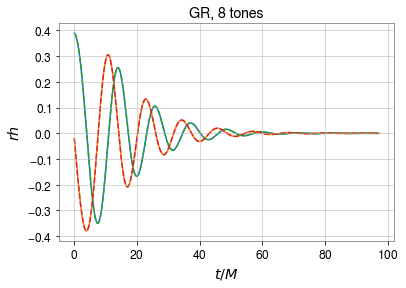

In [85]:
n=8
t_start = 0.0
t_RD = t_RD_22[t_RD_22>=t_start]
h_RD = h_RD_22[t_RD_22>=t_start]
h_RD_vec = np.hstack([np.real(h_RD), np.imag(h_RD)])
t_GR = np.copy(t_RD)
h_RD_GR_vec = np.copy(h_RD_vec)
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone_, np.hstack([t_RD,t_RD]), h_RD_vec,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec = damped_sine_complex_overtone(np.hstack([t_RD,t_RD]), *popt)
h_RD_fit_real = h_RD_fit_vec[:t_RD.size]
h_RD_fit_imag = h_RD_fit_vec[t_RD.size:]
h_RD_fit = h_RD_fit_real+h_RD_fit_imag*1j
mm = mismatch(h_RD, h_RD_fit, t_RD)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("GR, 8 tones")
plt.plot(t_RD, np.real(h_RD))
plt.plot(t_RD, np.imag(h_RD))
plt.plot(t_RD, h_RD_fit_real, ls='--')
plt.plot(t_RD, h_RD_fit_imag, ls='--')
plt.show()

[-1.87392869  0.94798397]
mismatch after the fit: 0.000623465


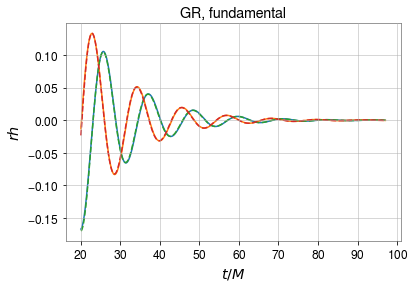

In [84]:
n=1
t_start = 20
t_RD = t_RD_22[t_RD_22>=t_start]
h_RD = h_RD_22[t_RD_22>=t_start]
h_RD_vec = np.hstack([np.real(h_RD), np.imag(h_RD)])

p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone_, np.hstack([t_RD,t_RD]), h_RD_vec,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec = damped_sine_complex_overtone_(np.hstack([t_RD,t_RD]), *popt)
h_RD_fit_real = h_RD_fit_vec[:t_RD.size]
h_RD_fit_imag = h_RD_fit_vec[t_RD.size:]
h_RD_fit = h_RD_fit_real+h_RD_fit_imag*1j
mm = mismatch(h_RD, h_RD_fit, t_RD)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("GR, fundamental")
plt.plot(t_RD, np.real(h_RD))
plt.plot(t_RD, np.imag(h_RD))
plt.plot(t_RD, h_RD_fit_real, ls='--')
plt.plot(t_RD, h_RD_fit_imag, ls='--')
plt.show()

In [91]:
ell=0.3
t_start = 0.0
strain_out=0.+0.j
time, strain_22 = dCS_hlm(ell,(2,2))
time, strain_2m2 = dCS_hlm(ell,(2,-2))
strain_22*=1#SpinWeightedSphericalHarmonic(0.0, 0, -2, mode[0], mode[1])
t_RD_22, h_RD_22 = get_ringdown(time, strain_22)
t_RD = t_RD_22[t_RD_22>=t_start]
h_RD = h_RD_22[t_RD_22>=t_start]
h_RD_vec = np.hstack([np.real(h_RD), np.imag(h_RD)])
t_RD_2m2, h_RD_2m2 = get_ringdown(time, strain_2m2)
mm_chiral=mismatch(h_RD_22, np.conj(h_RD_2m2), t_RD_22)
print("mismatch between 22 and 2-2 is %g" %mm_chiral)

mismatch between 22 and 2-2 is 1.19209e-07


[-0.24558287  2.13255796 -1.01088848  2.40398903 -0.43251077
 -3.14159254 -3.14159258  0.17235958  1.08522669  3.79383231
  9.65278641 18.08574279 17.39139142  1.53348662  9.3088658
  4.52349377]
mismatch after the fit: 1.96099e-05


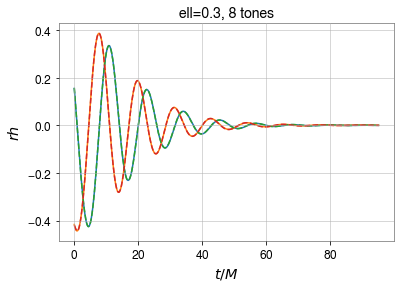

In [92]:
n=8
t_start = 0.0
t_RD = t_RD_22[t_RD_22>=t_start]
h_RD = h_RD_22[t_RD_22>=t_start]
h_RD_vec = np.hstack([np.real(h_RD), np.imag(h_RD)])
t_GR = np.copy(t_RD)
h_RD_GR_vec = np.copy(h_RD_vec)
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone_, np.hstack([t_RD,t_RD]), h_RD_vec,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec = damped_sine_complex_overtone(np.hstack([t_RD,t_RD]), *popt)
h_RD_fit_real = h_RD_fit_vec[:t_RD.size]
h_RD_fit_imag = h_RD_fit_vec[t_RD.size:]
h_RD_fit = h_RD_fit_real+h_RD_fit_imag*1j
mm = mismatch(h_RD, h_RD_fit, t_RD)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("ell=0.3, 8 tones")
plt.plot(t_RD, np.real(h_RD))
plt.plot(t_RD, np.imag(h_RD))
plt.plot(t_RD, h_RD_fit_real, ls='--')
plt.plot(t_RD, h_RD_fit_imag, ls='--')
plt.show()

[-0.20563259  1.05834401]
mismatch after the fit: 0.000913978


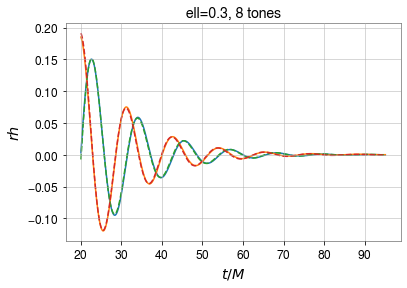

In [94]:
n=1
t_start = 20.0
t_RD = t_RD_22[t_RD_22>=t_start]
h_RD = h_RD_22[t_RD_22>=t_start]
h_RD_vec = np.hstack([np.real(h_RD), np.imag(h_RD)])
t_GR = np.copy(t_RD)
h_RD_GR_vec = np.copy(h_RD_vec)
p0_phis=[-0.5]*n
p0_As=[n+0.01]*n
p0=np.array([p0_phis,p0_As]).flatten()
plow=np.array([[-np.pi]*n,[1.e-3]*n]).flatten()
pup=np.array([[np.pi]*n,[100]*n]).flatten()
popt,pcov = curve_fit(damped_sine_complex_overtone_, np.hstack([t_RD,t_RD]), h_RD_vec,p0=p0, bounds = (plow,pup))
print(popt)

h_RD_fit_vec = damped_sine_complex_overtone_(np.hstack([t_RD,t_RD]), *popt)
h_RD_fit_real = h_RD_fit_vec[:t_RD.size]
h_RD_fit_imag = h_RD_fit_vec[t_RD.size:]
h_RD_fit = h_RD_fit_real+h_RD_fit_imag*1j
mm = mismatch(h_RD, h_RD_fit, t_RD)
print("mismatch after the fit: %g" %mm)

plt.figure()
plt.xlabel(r"$t/M$")
plt.ylabel(r"$rh$")
plt.title("ell=0.3, 8 tones")
plt.plot(t_RD, np.real(h_RD))
plt.plot(t_RD, np.imag(h_RD))
plt.plot(t_RD, h_RD_fit_real, ls='--')
plt.plot(t_RD, h_RD_fit_imag, ls='--')
plt.show()